# Importing libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

%matplotlib inline

from subprocess import check_output 

# Data filtering

In [4]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]
data = data[data.sentiment != 'Neutral']

train, test = train_test_split(data, test_size=0.1)

print(test[test.sentiment == 'Positive'].count())
print(test[test.sentiment == 'Negative'].count())

print(train[train.sentiment == 'Positive'].count())
print(train[train.sentiment == 'Negative'].count())

train_pos = train[train.sentiment == 'Positive']
train_pos = train_pos.text
train_neg = train[train.sentiment == 'Negative']
train_neg = train_neg.text

test_pos = test[test.sentiment == 'Positive']
test_pos = test_pos.text
test_neg = test[test.sentiment == 'Negative']
test_neg = test_neg.text

text         251
sentiment    251
dtype: int64
text         822
sentiment    822
dtype: int64
text         1985
sentiment    1985
dtype: int64
text         7671
sentiment    7671
dtype: int64


# Words wordcloud

In [6]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

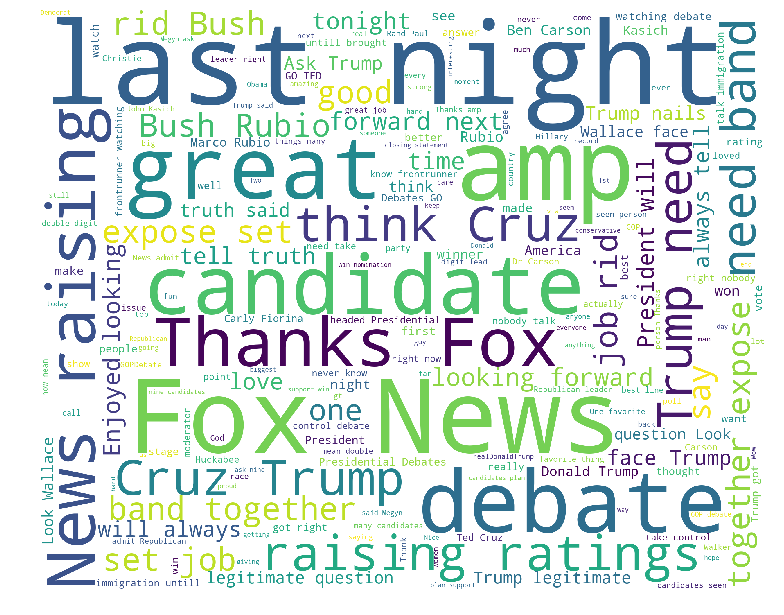

In [7]:
wordcloud_draw(train_pos, 'white')

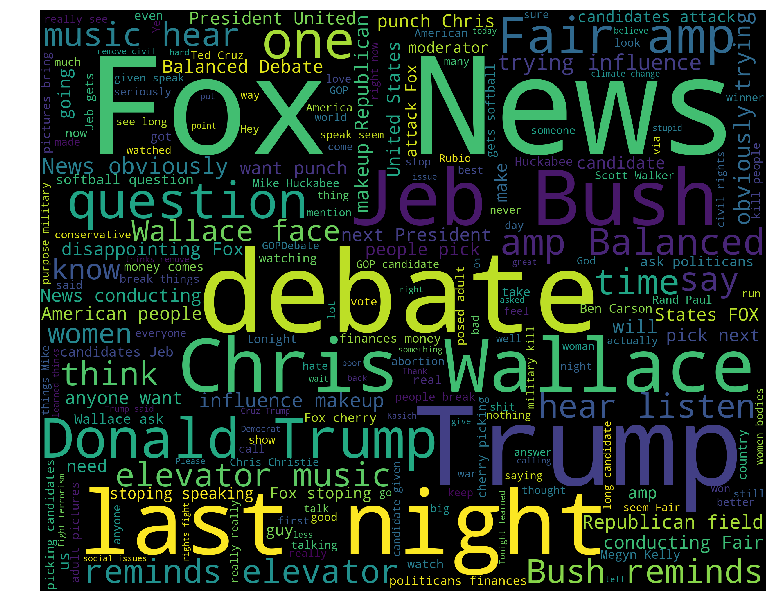

In [8]:
wordcloud_draw(train_neg, 'black')

#### переважно в позитивних твітах: "ruth, strong, legitimate, together, love, job"
#### переважно в негативних твітах: "influence, news, elevator music, disappointing, softball, makeup, cherry picking, trying"

# Deleting words like the, a, for, this etc(stopwords). Cleaning from hashtags, names and links.

In [9]:
tweets = []
# nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word 
        and not word.startswith('@') 
        and not word.startswith('#')]
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

In [10]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))
print(w_features)

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

dict_keys(['big', 'problem', 'facing', 'democrats', 'will', 'how', 'get', 'hillary', 'sober', 'long', 'enough', 'for', 'her', 'debate?', 'alissalyn14:', 'nylonmag:', 'the', 'most', 'insane,', 'ridiculous', 'quotes', 'from', 'last', "night's", 'seriously,', 'what', 'response', 'was', 'pathetic.', 'ben', 'carson:', 'trying', 'destroy', 'country', 'would', 'divide', 'people.', 'now', 'lets', 'talk', 'about', 'anti-lgbt', 'pro', 'war', 'plan…', 'goddamit,', 'donald.', 'your', 'soul', 'fumes', 'and', 'heart', 'orbits', 'dying', 'sun.', 'but', "you're", 'making', 'this', 'thing', 'interesting.', 'fuck…', '.@seanspicer', 'looks', 'like', 'has', 'broom', 'handle', 'foot', 'his', 'ass', 'talking', "it's", 'such', 'low', 'bar', 'set,', 'mostly', 'impressed', 'with', 'ability', 'act', 'had', 'some', 'sense', 'stage…', 'keep', 'religion', 'out', 'politics!', 'love', 'that', 'cruz', 'introduced', 'bill', 'strip', 'citizenship', 'americans', 'who', 'join', 'isis', 'rainbow', 'wigs', 'fire.', 'floppy

In [13]:
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [21]:
example = test_neg.iloc[0]
print(extract_features(example))

{'containts(big)': False, 'containts(problem)': False, 'containts(facing)': False, 'containts(democrats)': False, 'containts(will)': False, 'containts(how)': False, 'containts(get)': False, 'containts(hillary)': False, 'containts(sober)': False, 'containts(long)': False, 'containts(enough)': False, 'containts(for)': False, 'containts(her)': False, 'containts(debate?)': False, 'containts(alissalyn14:)': False, 'containts(nylonmag:)': False, 'containts(the)': False, 'containts(most)': False, 'containts(insane,)': False, 'containts(ridiculous)': False, 'containts(quotes)': False, 'containts(from)': False, 'containts(last)': False, "containts(night's)": False, 'containts(seriously,)': False, 'containts(what)': False, 'containts(response)': False, 'containts(was)': False, 'containts(pathetic.)': False, 'containts(ben)': False, 'containts(carson:)': False, 'containts(trying)': False, 'containts(destroy)': False, 'containts(country)': False, 'containts(would)': False, 'containts(divide)': Fal

In [92]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res = classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res = classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1

In [91]:
print('[Negative+Positive]: %s/%s percentage: %s'  % (neg_cnt+pos_cnt,len(test_neg)+len(test_pos),(neg_cnt+pos_cnt)/(len(test_neg)+len(test_pos))))

[Negative+Positive]: 883/1073 percentage: 0.8229263746505125


In [93]:
x1 = 'This is the best day in my life. I love it.'
x2 = '@realDonaldTrump need to take control of this debate,  they can do it, 🇺🇸'

y1 = 'Trump is the worst man in the world!'
y2 = 'Hilari isn\'t man enough to be president of USA.' 

a = [x1, x2, y1, y2]

for x in a:
    res = classifier.classify(extract_features(x.split()))
    print('%s: %s' % (res, x))

Positive: This is the best day in my life. I love it.
Positive: @realDonaldTrump need to take control of this debate,  they can do it, 🇺🇸
Negative: Trump is the worst man in the world!
Negative: Hilari isn't man enough to be president of USA.
